In [38]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import mstats
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [39]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [40]:
df = pd.read_csv('../../data/pre_train/aapl.csv')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.astype(float)

In [41]:
y = df['log_close']
X = df.drop('log_close', axis=1)

In [42]:
time_steps = 67
def create_sequences(X, y, time_steps=time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X.iloc[i:i + time_steps].values)
        y_seq.append(y.iloc[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

In [43]:
def evaluate_model(y_pred_train, y_pred_test, y_train, y_test):
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print("MAE train:", mae_train)
    print("MAE test:", mae_test)
    print("RMSE train:", rmse_train)
    print("RMSE test:", rmse_test)
    print("R2 train:", r2_train)
    print("R2 test:", r2_test)

In [44]:
def plot_predictions(y_test_real, y_pred_test_real):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_real, label="Real", color="blue")
    plt.plot(y_pred_test_real, label="Predicho", color="orange")
    plt.title("Predictions vs Real values")
    plt.legend()
    plt.show()

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [46]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [47]:
X_train_seq, y_train_seq = create_sequences(pd.DataFrame(X_train_scaled), y_train)
X_test_seq, y_test_seq = create_sequences(pd.DataFrame(X_test_scaled), y_test)

In [48]:
apply_pca = True
n_components = 10

if apply_pca:
    pca = PCA(n_components=n_components)
    X_train_seq_flat = X_train_seq.reshape(-1, X_train_seq.shape[-1])
    X_test_seq_flat = X_test_seq.reshape(-1, X_test_seq.shape[-1])
    
    X_train_pca = pca.fit_transform(X_train_seq_flat)
    X_test_pca = pca.transform(X_test_seq_flat)

    X_train_seq = X_train_pca.reshape(-1, time_steps, n_components)
    X_test_seq = X_test_pca.reshape(-1, time_steps, n_components)

In [49]:
scaler_y = MinMaxScaler()
y_train_seq_scaled = scaler_y.fit_transform(y_train_seq.reshape(-1, 1)).flatten()
y_test_seq_scaled = scaler_y.transform(y_test_seq.reshape(-1, 1)).flatten()

In [50]:
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), kernel_regularizer=l2(0.0005)),
    LSTM(128, return_sequences=False, kernel_regularizer=l2(0.0005)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [51]:
history = model.fit(
    X_train_seq, y_train_seq_scaled,
    epochs=50, batch_size=32, shuffle=False,
    validation_data=(X_test_seq, y_test_seq_scaled),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 282ms/step - loss: 0.3748 - mae: 0.2230 - val_loss: 0.2941 - val_mae: 0.1897
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - loss: 0.3644 - mae: 0.2752 - val_loss: 0.2385 - val_mae: 0.0822
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - loss: 0.3472 - mae: 0.3011 - val_loss: 0.2363 - val_mae: 0.1400
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 0.3531 - mae: 0.3113 - val_loss: 0.2072 - val_mae: 0.0975
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - loss: 0.3663 - mae: 0.3278 - val_loss: 0.2399 - val_mae: 0.2161
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.3757 - mae: 0.3750 - val_loss: 0.1883 - val_mae: 0.1130
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.3756 - mae: 0.3550 - val_loss: 0.1845 - val_mae: 0.1341
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - loss: 0.3390 - mae: 0.3265 - val_loss: 0.1705 - val_mae: 0.1242
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - l

In [52]:
y_pred_train_scaled = model.predict(X_train_seq)
y_pred_test_scaled = model.predict(X_test_seq)

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [53]:
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_train_true = scaler_y.inverse_transform(y_train_seq_scaled.reshape(-1, 1))
y_test_true = scaler_y.inverse_transform(y_test_seq_scaled.reshape(-1, 1))

In [54]:
evaluate_model(y_pred_train, y_pred_test, y_train_true, y_test_true)

MAE train: 0.17074732147648142
MAE test: 0.08847611676457946
RMSE train: 0.1909778767795243
RMSE test: 0.0992703018063961
R2 train: 0.29125875122473144
R2 test: 0.2093146906179174


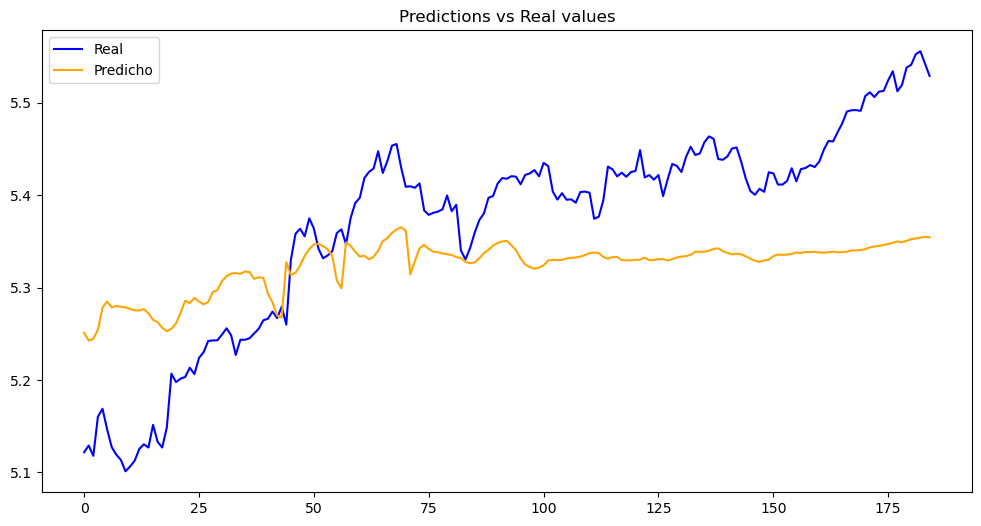

In [55]:
plot_predictions(y_test_true, y_pred_test)